WIP notebook to test the VAE-based counterfactual data augmentation module from CLAIRE on a dummy dataset.

Implemention at `src/claire_cf_data_augmentation.py`.

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Dummy data

In [3]:
class DummyDataset(Dataset):
    def __init__(self, X, Y, S):
        """
        Args:
            X: Input features
            Y: Labels
            S: Sensitive attributes
        """
        self.X = X
        self.Y = Y
        self.S = S

    def __len__(self):
        """Return the total number of samples."""
        return len(self.X)

    def __getitem__(self, idx):
        """Return a single sample from the dataset at index `idx`."""
        x = self.X[idx]
        y = self.Y[idx]
        s = self.S[idx]
        return x, y, s

In [4]:
X_train_example = torch.randn(1000, 5)  # Input features {X} (e.g., 1000 samples, 9 features)
Y_train_example = torch.randn(1000, 1)  # Labels {Y} (e.g., 1000 samples, 1 label)
S_train_example = torch.randint(0, 2, (1000, 1))  # Sensitive attributes {S} (binary)

# Y_train_example = (Y_train_example > 0).float()  # Convert to binary labels

X_train_example.shape, Y_train_example.shape, S_train_example.shape 

(torch.Size([1000, 5]), torch.Size([1000, 1]), torch.Size([1000, 1]))

In [5]:
train_dataset = DummyDataset(X_train_example, Y_train_example, S_train_example)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

In [6]:
len(train_dataloader)  # Number of batches in the dataloader

31

In [7]:
len(train_dataloader) * train_dataloader.batch_size  # Number of samples in the dataloader

992

# VAE loss

In [8]:
from src.claire_cf_data_augmentation import vae_loss

c:\Users\DELL\Documents\MS\UMich\Courses\FA24\CSE 598\causalml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
x = torch.randn(32, 10)        # Original input
recon_x = torch.randn(32, 10)  # Reconstructed input
mu = torch.randn(32, 20)       # Mean from the encoder's latent space
logvar = torch.randn(32, 20)   # Log variance from the encoder's latent space

vae_loss(recon_x, x, mu, logvar)

tensor(18.9936)

In [10]:
vae_loss(x, x, mu, logvar)

tensor(16.7566)

# MMD loss

- Small if two distributions are similar and large if they are different.

In [11]:
from src.claire_cf_data_augmentation import mmd_loss

In [12]:
H1 = torch.randn(1, 20) 
H2 = H1.clone()

mmd_loss(H1, H2)

tensor(0.)

In [13]:
H3 = H1.clone() + 0.1

mmd_loss(H1, H3)

tensor(0.1903)

# CLAIRE-M loss function

In [14]:
from src.claire_cf_data_augmentation import claire_m_loss

vae_loss = torch.tensor(1.0) 

embeddings_by_group = {
    'group1': torch.randn(32, 10),
    'group2': torch.randn(32, 10),
}

loss = claire_m_loss(vae_loss, embeddings_by_group)
print("CLAIRE-M Loss:", loss.item())

CLAIRE-M Loss: 1.1240620613098145


# Train VAE for counterfactual data generation

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [16]:
from src.claire_cf_data_augmentation import VAE

vae = VAE(input_dim=X_train_example.shape[1], latent_dim=20)
vae.to(device)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=6, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=20, bias=True)
    (fc_var): Linear(in_features=32, out_features=20, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=21, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=6, bias=True)
    (activation): LeakyReLU(negative_slope=0.01)
  )
)

In [17]:
from src.claire_cf_data_augmentation import train

vae, vae_train_loss = train(vae, train_dataloader, num_epochs=100)

  1%|          | 1/100 [00:00<00:16,  6.07epochs/s]

Epoch [1/100], Loss: 2.4652


  2%|▏         | 2/100 [00:00<00:13,  7.32epochs/s]

Epoch [2/100], Loss: 2.3043


  3%|▎         | 3/100 [00:00<00:11,  8.17epochs/s]

Epoch [3/100], Loss: 2.1749


  4%|▍         | 4/100 [00:00<00:11,  8.51epochs/s]

Epoch [4/100], Loss: 2.0738


  5%|▌         | 5/100 [00:00<00:10,  8.83epochs/s]

Epoch [5/100], Loss: 1.9814


  6%|▌         | 6/100 [00:00<00:10,  9.09epochs/s]

Epoch [6/100], Loss: 1.8947


  7%|▋         | 7/100 [00:00<00:10,  9.20epochs/s]

Epoch [7/100], Loss: 1.8298


  8%|▊         | 8/100 [00:00<00:09,  9.32epochs/s]

Epoch [8/100], Loss: 1.7675


  9%|▉         | 9/100 [00:01<00:09,  9.33epochs/s]

Epoch [9/100], Loss: 1.7065


 10%|█         | 10/100 [00:01<00:09,  9.45epochs/s]

Epoch [10/100], Loss: 1.6762


 11%|█         | 11/100 [00:01<00:09,  9.39epochs/s]

Epoch [11/100], Loss: 1.6304


 12%|█▏        | 12/100 [00:01<00:09,  9.40epochs/s]

Epoch [12/100], Loss: 1.5991


 13%|█▎        | 13/100 [00:01<00:09,  9.43epochs/s]

Epoch [13/100], Loss: 1.5690


 14%|█▍        | 14/100 [00:01<00:10,  7.96epochs/s]

Epoch [14/100], Loss: 1.5549


 15%|█▌        | 15/100 [00:01<00:10,  8.35epochs/s]

Epoch [15/100], Loss: 1.5230


 16%|█▌        | 16/100 [00:01<00:09,  8.51epochs/s]

Epoch [16/100], Loss: 1.4981


 17%|█▋        | 17/100 [00:01<00:09,  8.72epochs/s]

Epoch [17/100], Loss: 1.4881


 18%|█▊        | 18/100 [00:02<00:09,  8.96epochs/s]

Epoch [18/100], Loss: 1.4700


 19%|█▉        | 19/100 [00:02<00:08,  9.03epochs/s]

Epoch [19/100], Loss: 1.4620


 20%|██        | 20/100 [00:02<00:08,  9.22epochs/s]

Epoch [20/100], Loss: 1.4297


 21%|██        | 21/100 [00:02<00:08,  9.37epochs/s]

Epoch [21/100], Loss: 1.4281


 22%|██▏       | 22/100 [00:02<00:08,  9.19epochs/s]

Epoch [22/100], Loss: 1.4224


 23%|██▎       | 23/100 [00:02<00:08,  9.06epochs/s]

Epoch [23/100], Loss: 1.4053


 24%|██▍       | 24/100 [00:02<00:09,  8.42epochs/s]

Epoch [24/100], Loss: 1.3927


 25%|██▌       | 25/100 [00:02<00:08,  8.72epochs/s]

Epoch [25/100], Loss: 1.3871


 26%|██▌       | 26/100 [00:02<00:08,  8.82epochs/s]

Epoch [26/100], Loss: 1.3873


 27%|██▋       | 27/100 [00:03<00:08,  8.99epochs/s]

Epoch [27/100], Loss: 1.3745


 28%|██▊       | 28/100 [00:03<00:07,  9.12epochs/s]

Epoch [28/100], Loss: 1.3777


 29%|██▉       | 29/100 [00:03<00:07,  9.10epochs/s]

Epoch [29/100], Loss: 1.3580


 30%|███       | 30/100 [00:03<00:08,  8.74epochs/s]

Epoch [30/100], Loss: 1.3689


 31%|███       | 31/100 [00:03<00:07,  8.77epochs/s]

Epoch [31/100], Loss: 1.3603


 32%|███▏      | 32/100 [00:03<00:07,  8.80epochs/s]

Epoch [32/100], Loss: 1.3527


 33%|███▎      | 33/100 [00:03<00:08,  8.20epochs/s]

Epoch [33/100], Loss: 1.3448


 34%|███▍      | 34/100 [00:03<00:08,  7.34epochs/s]

Epoch [34/100], Loss: 1.3560


 35%|███▌      | 35/100 [00:04<00:08,  7.78epochs/s]

Epoch [35/100], Loss: 1.3365


 36%|███▌      | 36/100 [00:04<00:07,  8.27epochs/s]

Epoch [36/100], Loss: 1.3324


 37%|███▋      | 37/100 [00:04<00:07,  8.55epochs/s]

Epoch [37/100], Loss: 1.3290


 38%|███▊      | 38/100 [00:04<00:07,  8.46epochs/s]

Epoch [38/100], Loss: 1.3317


 39%|███▉      | 39/100 [00:04<00:07,  8.25epochs/s]

Epoch [39/100], Loss: 1.3294


 40%|████      | 40/100 [00:04<00:07,  8.00epochs/s]

Epoch [40/100], Loss: 1.3262


 41%|████      | 41/100 [00:04<00:07,  7.87epochs/s]

Epoch [41/100], Loss: 1.3209


 42%|████▏     | 42/100 [00:04<00:07,  7.98epochs/s]

Epoch [42/100], Loss: 1.3183


 43%|████▎     | 43/100 [00:05<00:07,  8.02epochs/s]

Epoch [43/100], Loss: 1.3150


 44%|████▍     | 44/100 [00:05<00:06,  8.10epochs/s]

Epoch [44/100], Loss: 1.3246


 45%|████▌     | 45/100 [00:05<00:06,  8.17epochs/s]

Epoch [45/100], Loss: 1.3108


 46%|████▌     | 46/100 [00:05<00:06,  8.22epochs/s]

Epoch [46/100], Loss: 1.3193


 47%|████▋     | 47/100 [00:05<00:06,  8.38epochs/s]

Epoch [47/100], Loss: 1.3135


 48%|████▊     | 48/100 [00:05<00:06,  8.27epochs/s]

Epoch [48/100], Loss: 1.3094


 49%|████▉     | 49/100 [00:05<00:06,  8.15epochs/s]

Epoch [49/100], Loss: 1.3090


 50%|█████     | 50/100 [00:05<00:06,  8.22epochs/s]

Epoch [50/100], Loss: 1.3083


 51%|█████     | 51/100 [00:05<00:05,  8.38epochs/s]

Epoch [51/100], Loss: 1.3068


 52%|█████▏    | 52/100 [00:06<00:05,  8.39epochs/s]

Epoch [52/100], Loss: 1.2982


 53%|█████▎    | 53/100 [00:06<00:05,  8.45epochs/s]

Epoch [53/100], Loss: 1.3024


 54%|█████▍    | 54/100 [00:06<00:06,  7.16epochs/s]

Epoch [54/100], Loss: 1.2983


 55%|█████▌    | 55/100 [00:06<00:06,  7.38epochs/s]

Epoch [55/100], Loss: 1.3002


 56%|█████▌    | 56/100 [00:06<00:05,  7.68epochs/s]

Epoch [56/100], Loss: 1.3071


 57%|█████▋    | 57/100 [00:06<00:05,  7.87epochs/s]

Epoch [57/100], Loss: 1.2982


 58%|█████▊    | 58/100 [00:06<00:05,  8.06epochs/s]

Epoch [58/100], Loss: 1.2950


 59%|█████▉    | 59/100 [00:06<00:05,  8.19epochs/s]

Epoch [59/100], Loss: 1.2905


 60%|██████    | 60/100 [00:07<00:04,  8.23epochs/s]

Epoch [60/100], Loss: 1.2920


 61%|██████    | 61/100 [00:07<00:04,  8.42epochs/s]

Epoch [61/100], Loss: 1.2922


 62%|██████▏   | 62/100 [00:07<00:04,  8.56epochs/s]

Epoch [62/100], Loss: 1.2962


 63%|██████▎   | 63/100 [00:07<00:04,  8.69epochs/s]

Epoch [63/100], Loss: 1.2842


 64%|██████▍   | 64/100 [00:07<00:04,  8.64epochs/s]

Epoch [64/100], Loss: 1.2923


 65%|██████▌   | 65/100 [00:07<00:03,  8.88epochs/s]

Epoch [65/100], Loss: 1.2901


 66%|██████▌   | 66/100 [00:07<00:03,  8.75epochs/s]

Epoch [66/100], Loss: 1.2855


 67%|██████▋   | 67/100 [00:07<00:03,  8.32epochs/s]

Epoch [67/100], Loss: 1.2837


 68%|██████▊   | 68/100 [00:08<00:03,  8.49epochs/s]

Epoch [68/100], Loss: 1.2824


 69%|██████▉   | 69/100 [00:08<00:03,  8.81epochs/s]

Epoch [69/100], Loss: 1.2975


 70%|███████   | 70/100 [00:08<00:03,  8.92epochs/s]

Epoch [70/100], Loss: 1.2821


 71%|███████   | 71/100 [00:08<00:03,  9.07epochs/s]

Epoch [71/100], Loss: 1.2779


 72%|███████▏  | 72/100 [00:08<00:03,  8.97epochs/s]

Epoch [72/100], Loss: 1.2855


 73%|███████▎  | 73/100 [00:08<00:03,  7.56epochs/s]

Epoch [73/100], Loss: 1.2787


 74%|███████▍  | 74/100 [00:08<00:03,  6.88epochs/s]

Epoch [74/100], Loss: 1.2851


 75%|███████▌  | 75/100 [00:08<00:03,  7.06epochs/s]

Epoch [75/100], Loss: 1.2711


 76%|███████▌  | 76/100 [00:09<00:03,  7.29epochs/s]

Epoch [76/100], Loss: 1.2739


 77%|███████▋  | 77/100 [00:09<00:03,  7.60epochs/s]

Epoch [77/100], Loss: 1.2730


 78%|███████▊  | 78/100 [00:09<00:02,  7.70epochs/s]

Epoch [78/100], Loss: 1.2667


 79%|███████▉  | 79/100 [00:09<00:02,  7.87epochs/s]

Epoch [79/100], Loss: 1.2701


 80%|████████  | 80/100 [00:09<00:02,  8.11epochs/s]

Epoch [80/100], Loss: 1.2737


 81%|████████  | 81/100 [00:09<00:02,  8.43epochs/s]

Epoch [81/100], Loss: 1.2713


 82%|████████▏ | 82/100 [00:09<00:02,  8.41epochs/s]

Epoch [82/100], Loss: 1.2764


 83%|████████▎ | 83/100 [00:09<00:02,  8.33epochs/s]

Epoch [83/100], Loss: 1.2745


 84%|████████▍ | 84/100 [00:10<00:01,  8.36epochs/s]

Epoch [84/100], Loss: 1.2730


 85%|████████▌ | 85/100 [00:10<00:01,  8.59epochs/s]

Epoch [85/100], Loss: 1.2665


 86%|████████▌ | 86/100 [00:10<00:01,  8.76epochs/s]

Epoch [86/100], Loss: 1.2754


 87%|████████▋ | 87/100 [00:10<00:01,  8.64epochs/s]

Epoch [87/100], Loss: 1.2704


 88%|████████▊ | 88/100 [00:10<00:01,  8.67epochs/s]

Epoch [88/100], Loss: 1.2721


 89%|████████▉ | 89/100 [00:10<00:01,  8.60epochs/s]

Epoch [89/100], Loss: 1.2725


 90%|█████████ | 90/100 [00:10<00:01,  8.61epochs/s]

Epoch [90/100], Loss: 1.2662


 91%|█████████ | 91/100 [00:10<00:01,  7.12epochs/s]

Epoch [91/100], Loss: 1.2633


 92%|█████████▏| 92/100 [00:11<00:01,  6.93epochs/s]

Epoch [92/100], Loss: 1.2645


 93%|█████████▎| 93/100 [00:11<00:00,  7.15epochs/s]

Epoch [93/100], Loss: 1.2746


 94%|█████████▍| 94/100 [00:11<00:00,  7.51epochs/s]

Epoch [94/100], Loss: 1.2605


 95%|█████████▌| 95/100 [00:11<00:00,  7.21epochs/s]

Epoch [95/100], Loss: 1.2655


 96%|█████████▌| 96/100 [00:11<00:00,  7.28epochs/s]

Epoch [96/100], Loss: 1.2611


 97%|█████████▋| 97/100 [00:11<00:00,  7.67epochs/s]

Epoch [97/100], Loss: 1.2652


 98%|█████████▊| 98/100 [00:11<00:00,  8.04epochs/s]

Epoch [98/100], Loss: 1.2619


 99%|█████████▉| 99/100 [00:11<00:00,  8.26epochs/s]

Epoch [99/100], Loss: 1.2605


100%|██████████| 100/100 [00:12<00:00,  8.30epochs/s]

Epoch [100/100], Loss: 1.2644


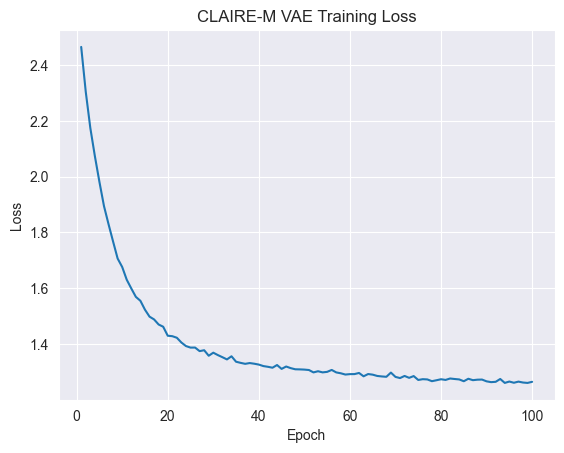

In [18]:
plt.plot(range(1, len(vae_train_loss) + 1), vae_train_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CLAIRE-M VAE Training Loss")
plt.show()

# Generate counterfactuals

In [19]:
from src.claire_cf_data_augmentation import CounterfactualDataGenerator

cf_gen = CounterfactualDataGenerator(vae, sensitive_groups=[0, 1])

In [20]:
train_dataset = DummyDataset(X_train_example, Y_train_example, S_train_example)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

X_CF = {0: [], 1: []} 
Y_CF = {0: [], 1: []}

for X_batch, Y_batch, S_batch in train_dataloader:
    X_cf_batch, Y_cf_batch = cf_gen.generate_counterfactuals(X_batch, Y_batch)
    for s in X_cf_batch.keys():
        X_CF[s].append(X_cf_batch[s])
        Y_CF[s].append(Y_cf_batch[s])

In [21]:
orig_df = pd.DataFrame(X_train_example, columns=[f"X{i}" for i in range(X_batch.shape[1])])
orig_df["S"] = S_train_example
orig_df["Y"] = Y_train_example

In [22]:
cf0_df = pd.DataFrame(np.vstack(X_CF[0]), columns=[f"X{i}" for i in range(X_train_example.shape[1])])
cf0_df["S"] = 0
cf0_df["Y"] = np.vstack(Y_CF[0])

cf1_df = pd.DataFrame(np.vstack(X_CF[1]), columns=[f"X{i}" for i in range(X_train_example.shape[1])])
cf1_df["S"] = 1
cf1_df["Y"] = np.vstack(Y_CF[1])

cf_df = pd.concat([cf0_df, cf1_df], ignore_index=True)

In [23]:
len(orig_df), len(cf_df)

(1000, 1984)

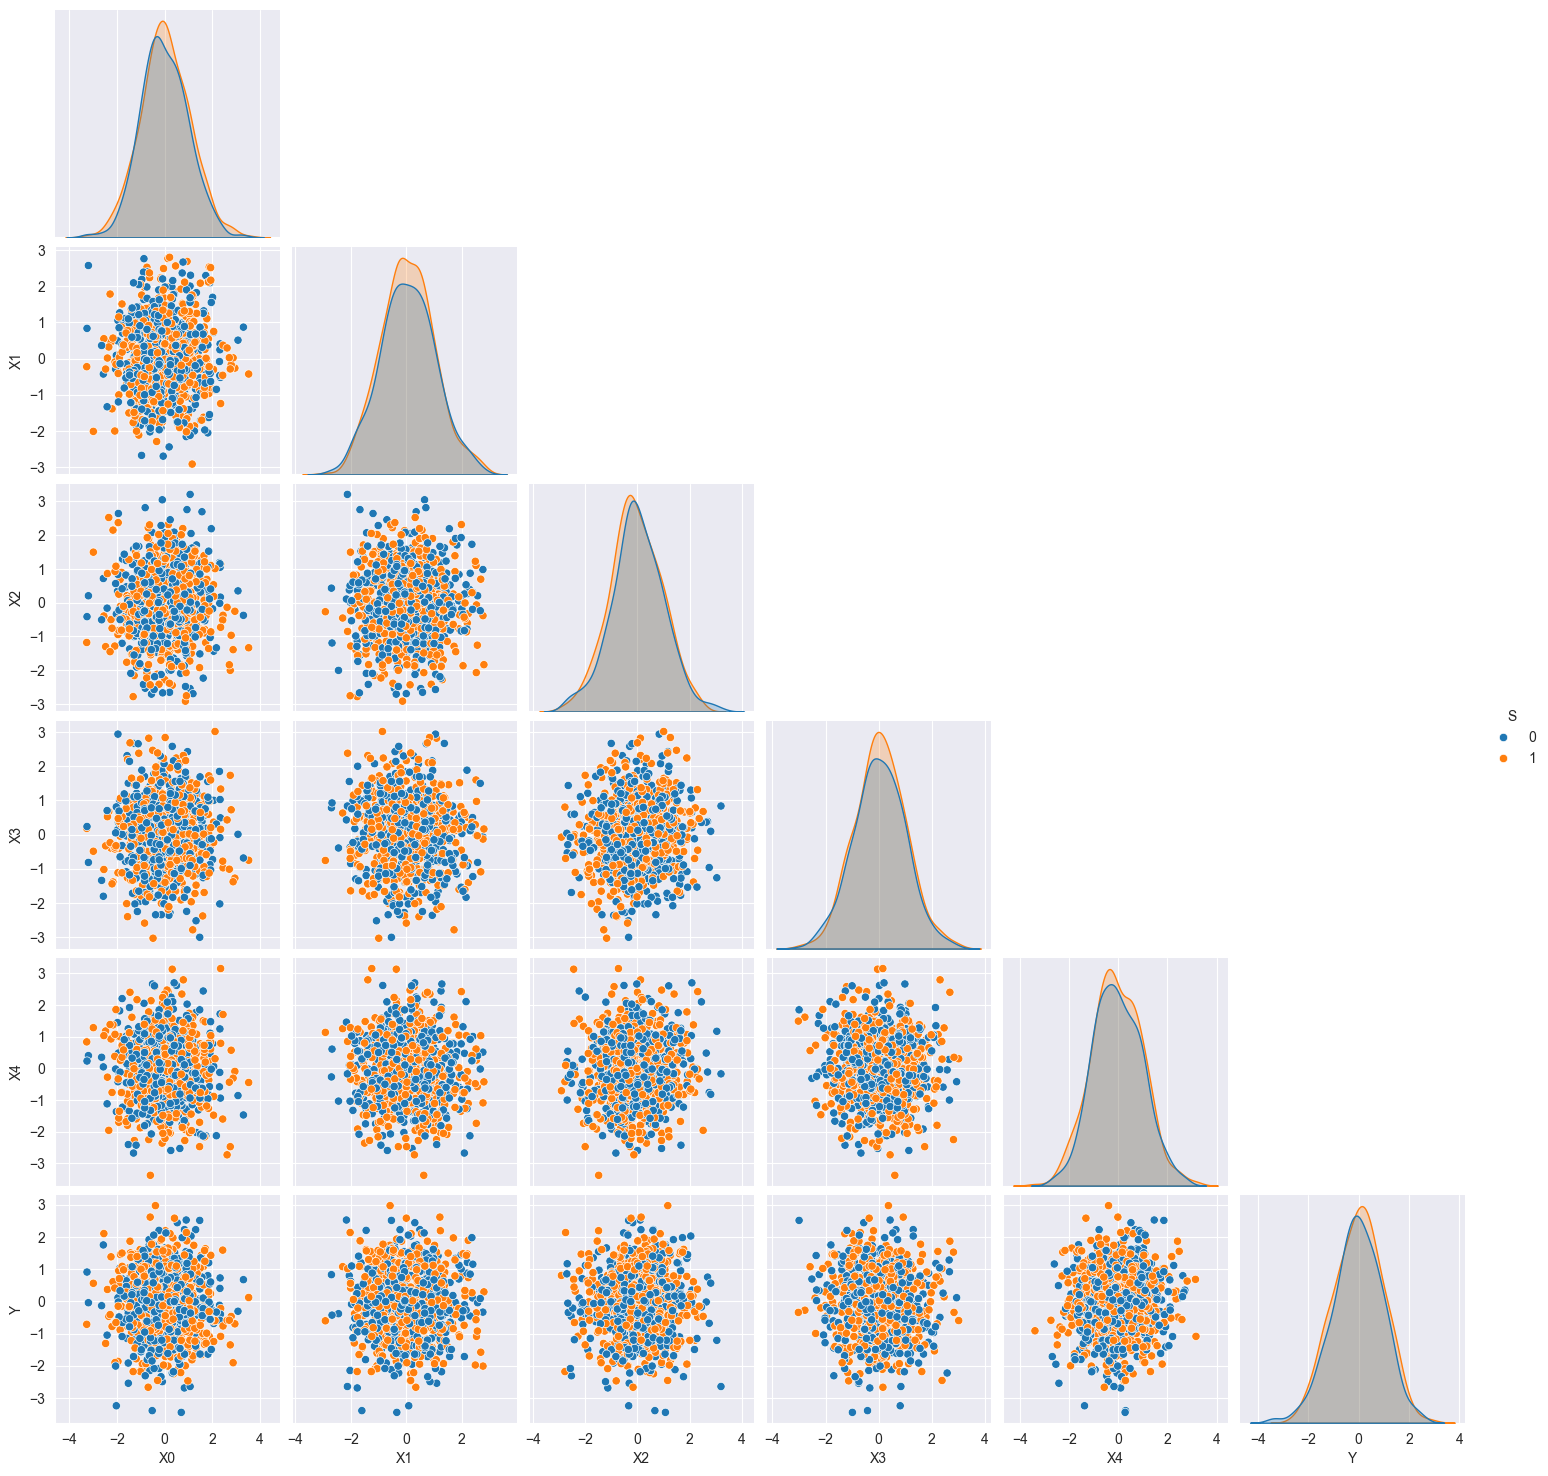

In [24]:
sns.pairplot(orig_df, hue="S", diag_kind="kde", corner=True)

Text(0.5, 0.98, 'Distribution of Generated Counterfactual Data')

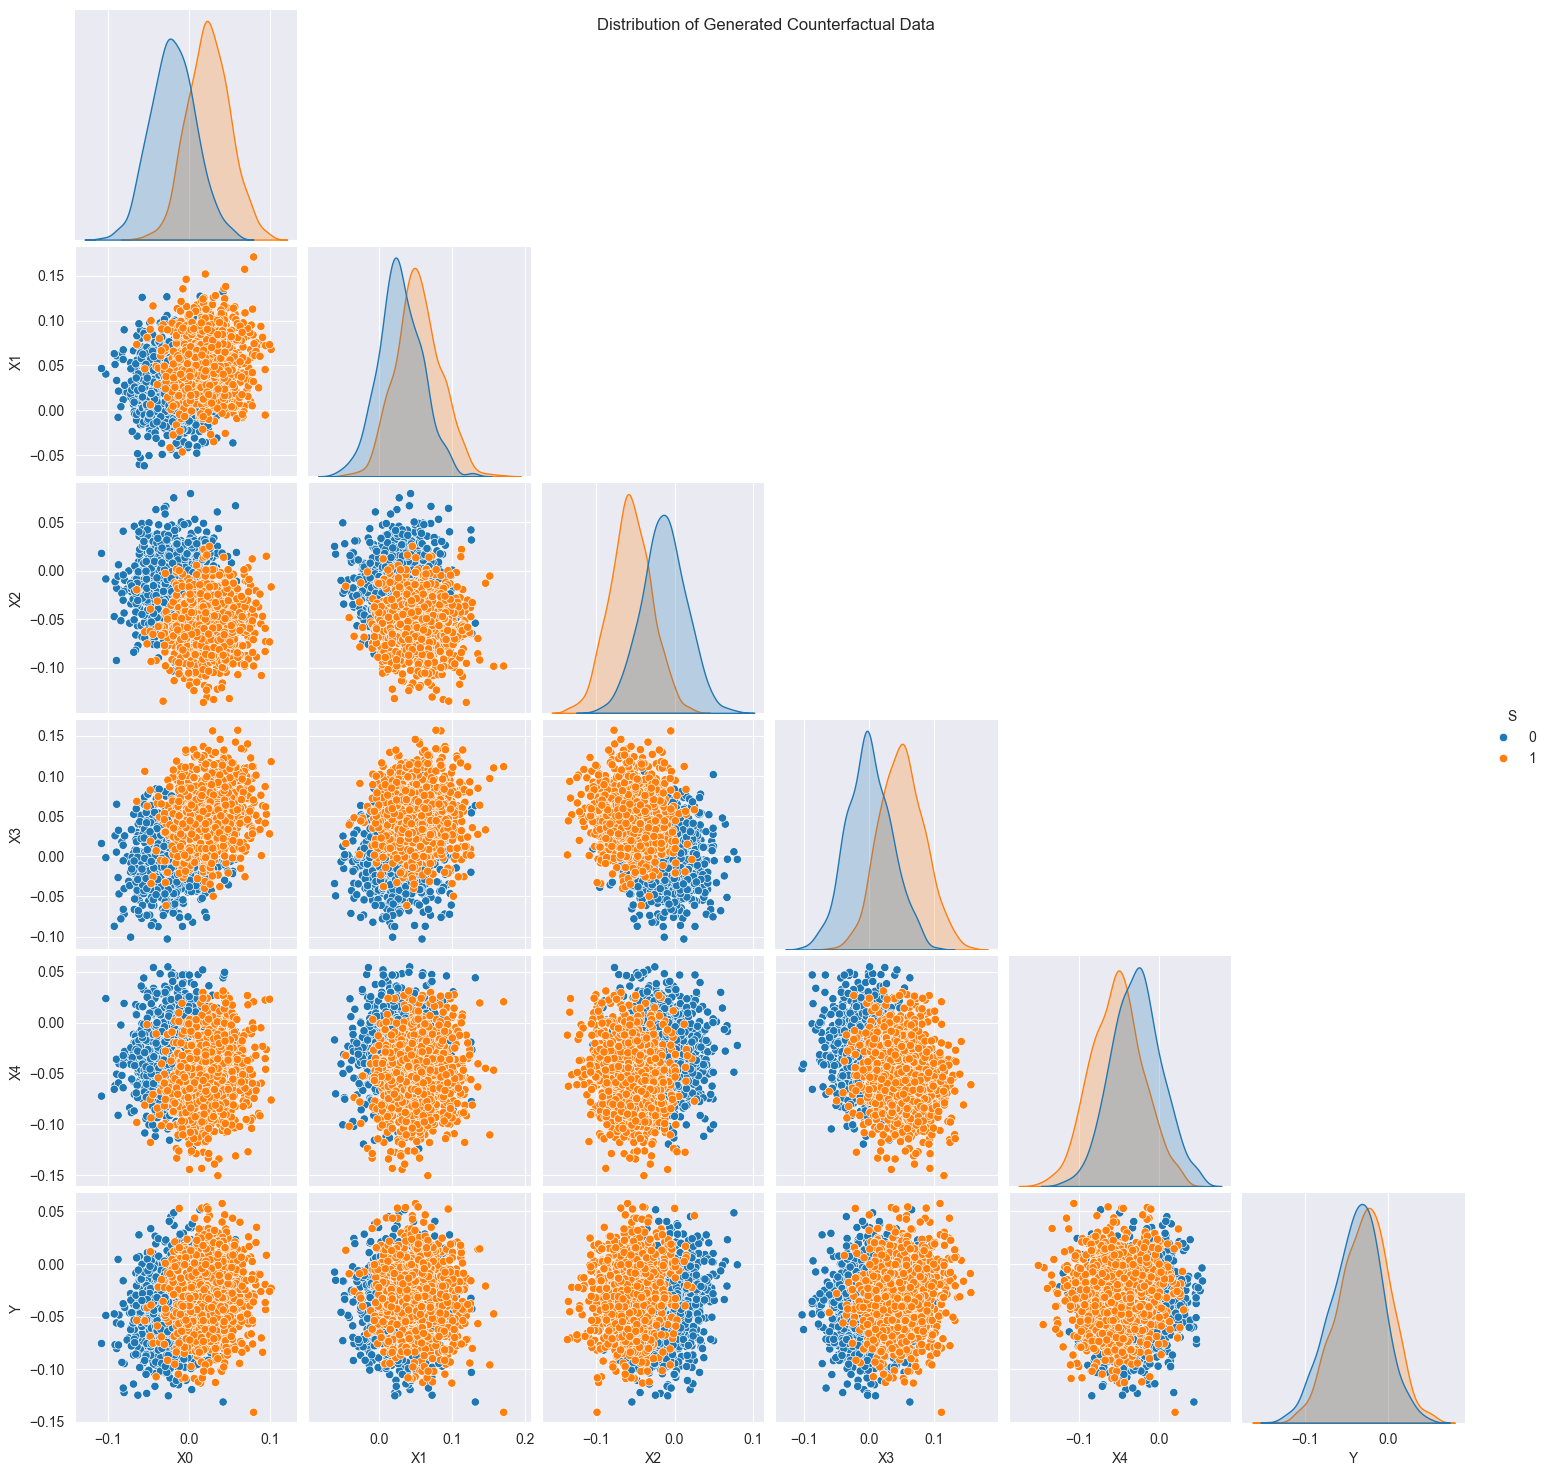

In [25]:
sns.pairplot(cf_df, hue="S", diag_kind="kde", corner=True)
plt.suptitle("Distribution of Generated Counterfactual Data")